In [ ]:
# Set user-agent for the browser
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'
}

# Initialize the Edge webdriver
driver = webdriver.Edge() 

# URL of the product page
product_url = 'https://www.flipkart.com/mi-series-80-cm-32-inch-hd-ready-led-smart-google-tv-2023-dolby-audio-dts-hd-vivid-picture-engine/product-reviews/itmf15b4727d84f5?pid=TVSGREPAZX8CN9QS&lid=LSTTVSGREPAZX8CN9QSFY3T6T&marketplace=FLIPKART'

# Number of pages to scrape (adjust this based on the total number of reviews)
total_pages = 230

# Lists to store scraped data
ratings = []
Short_Reviews = []
names = []
dates = []
reviews = []
likes = []
images = []
Dislikes = []

# Iterate through each page
for page in range(total_pages):
    # Construct URL for the current page
    url = f"{product_url}&page={page + 1}"
    
    # Open the URL
    driver.get(url)
    
    # Simulate scrolling down to load more reviews
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)  # Wait for the content to load
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find all the reviews on the page
    all_reviews = soup.find_all('div', {'class': "_27M-vq"})

    # Loop through each review and extract the required data
    for review in all_reviews:
        rating_element = review.find('div', {'class': "_3LWZlK"})
        if rating_element:
            rating = rating_element.text.strip()
            ratings.append(rating)

        Short_Review = review.find('p', {'class': "_2-N8zT"}).text.strip()
        if len(Short_Review) >= 1:
            Short_Reviews.append(Short_Review)
        else:
            Short_Reviews.append('Blank')

        review_text_element = review.find('div', {'class': "t-ZTKy"}).text.strip()
        if review_text_element:
            # Split the review text into words
            words = review_text_element.split()
            # Remove 'READ' and 'MORE' from the words list
            words = [word for word in words if word.upper() != 'READ' and word.upper() != 'MORE']
            # Reconstruct the sentence
            review_text = ' '.join(words)
            if len(review_text) >= 1:
                reviews.append(review_text)
            else:
                reviews.append('Blank')

        name = review.find('p', {'class': '_2sc7ZR _2V5EHH'}).text.strip()
        names.append(name)

        dates_elements = review.find_all('p', {'class': "_2sc7ZR"})
        if len(dates_elements) >= 2:
            Date = dates_elements[1].text.strip()
            dates.append(Date)

        like = review.find('span', {'class': '_3c3Px5'}).text.strip()
        likes.append(like)

        dislike_elements = review.find_all('span', {'class': '_3c3Px5'})

        # Check if there is more than one element with class '_3c3Px5'
        if len(dislike_elements) > 1:
            # Get the second element and extract its text
            dislike = dislike_elements[1].text.strip()
            Dislikes.append(dislike)
        else:
            # If there is only one element, append an empty string or any default value
            Dislikes.append('')

        image = review.find_all('div', {'class': "_21YjFX _2A07HP"})
        images.append(len(image))

# Close the webdriver
driver.quit()

# Create a dictionary with the extracted data
data = {'Rating': ratings, 'Short_Reviews': Short_Reviews, 'reviews': reviews, 'Names': names, 'Dates': dates,
        'Likes': likes, 'Dislikes': Dislikes, 'Number_Images': images}

# Print or save the data as required
print(data)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.to_csv('reviews.csv', index=False)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
import emoji
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prajj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prajj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prajj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("reviews.csv")

In [4]:
df.head()

,Rating,Short_Reviews,reviews,Names,Dates,Likes,Dislikes,Number_Images
0,5,Must buy!,NiceREAD,Rupesh Kumar,1 month ago,86,24,1
1,5,Mind-blowing purchase,Good 👍👍👍READ,Flipkart Customer,2 months ago,39,9,1
2,5,Terrific purchase,I Love this mi tv. All good no problem on this...,DAITARI MAJHI,4 months ago,41,11,3
3,5,Must buy!,"Very good product, picture quality awesomeREAD",Bapi Saha,4 months ago,28,8,2
4,1,Hated it!,Display picture is worst 😭READ,Jagajeevan Reddy,2 months ago,25,7,0


In [5]:
df["reviews"]

0                                                NiceREAD
1                                            Good 👍👍👍READ
2       I Love this mi tv. All good no problem on this...
3          Very good product, picture quality awesomeREAD
4                          Display picture is worst 😭READ
                              ...                        
2295                                          Not badREAD
2296    Nice product sound quality is awesome and scre...
2297    Product is good but picture quality is ot good...
2298                                 Good product 👍👍👍READ
2299                                        Very goodREAD
Name: reviews, Length: 2300, dtype: object

In [6]:
# Removing word "READ" from each review in reviews column
df['reviews'] = df['reviews'].str.replace('READ', '', regex=False)

In [7]:
df["reviews"]

0                                                    Nice
1                                                Good 👍👍👍
2       I Love this mi tv. All good no problem on this...
3              Very good product, picture quality awesome
4                              Display picture is worst 😭
                              ...                        
2295                                              Not bad
2296    Nice product sound quality is awesome and scre...
2297       Product is good but picture quality is ot good
2298                                     Good product 👍👍👍
2299                                            Very good
Name: reviews, Length: 2300, dtype: object

In [8]:
# Initialize WordNetLemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
regexp = RegexpTokenizer('\w+')
# Function to preprocess and lemmatize the reviews
def preprocess_and_lemmatize(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = regexp.tokenize(text)
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the lemmatized tokens back into text
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Apply preprocessing and lemmatization to the 'reviews' column
df['Processed_Reviews'] = df['reviews'].apply(preprocess_and_lemmatize)



In [9]:
df.head(3)

,Rating,Short_Reviews,reviews,Names,Dates,Likes,Dislikes,Number_Images,Processed_Reviews
0,5,Must buy!,Nice,Rupesh Kumar,1 month ago,86,24,1,nice
1,5,Mind-blowing purchase,Good 👍👍👍,Flipkart Customer,2 months ago,39,9,1,good
2,5,Terrific purchase,I Love this mi tv. All good no problem on this...,DAITARI MAJHI,4 months ago,41,11,3,love mi tv good problem tv


In [10]:
df["Processed_Reviews"]

0                                                    nice
1                                                    good
2                              love mi tv good problem tv
3                    good product picture quality awesome
4                                   display picture worst
                              ...                        
2295                                                  bad
2296    nice product sound quality awesome screen qual...
2297                 product good picture quality ot good
2298                                         good product
2299                                                 good
Name: Processed_Reviews, Length: 2300, dtype: object

# Sentimental score

In [11]:
# Function to get sentiment score using TextBlob
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the 'Processed_Reviews' column
df['Sentiment_Score'] = df['Processed_Reviews'].apply(get_sentiment_score)

# Categorize the sentiment
df['Sentiment'] = df['Sentiment_Score'].apply(lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral')

# Overall sentiment
overall_sentiment = df['Sentiment'].value_counts(normalize=True)
print("Overall Sentiment Distribution:")
print(overall_sentiment)

Overall Sentiment Distribution:
Positive    0.873043
Neutral     0.091304
Negative    0.035652
Name: Sentiment, dtype: float64


The overall sentiment distribution indicates the following:

Positive Sentiment: Approximately 87.30% of the reviews are categorized as positive. This suggests that a majority of the reviews express positive sentiments towards the "Mi A series HD LED Smart TV".

Neutral Sentiment: Around 9.13% of the reviews are categorized as neutral. These reviews may not express strong positive or negative sentiments. They could be more factual or descriptive in nature.

Negative Sentiment: Only about 3.56% of the reviews are categorized as negative. This indicates that a very small portion of the reviews express negative sentiments towards the product.

Based on this sentiment distribution, it seems that the product generally receives positive feedback from customers. However, it's essential to further analyze the negative sentiment reviews to address any potential issues or concerns customers may have. Additionally, understanding the neutral sentiment reviews can provide insights into areas where the product could be improved or further developed to meet customer expectations.

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

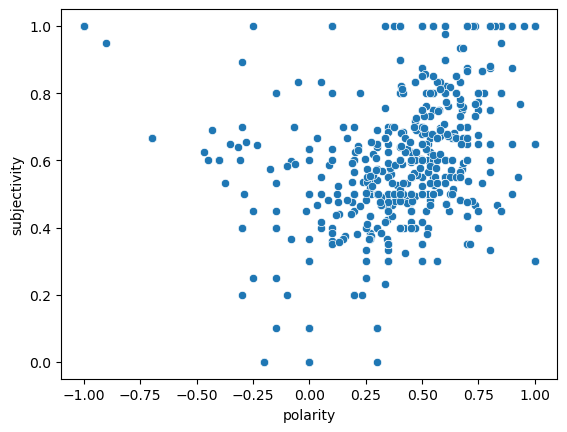

In [12]:
df[['polarity', 'subjectivity']] = df['Processed_Reviews'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
sns.scatterplot(x = df['polarity'],y= df['subjectivity'])

In [13]:
all_words = ' '.join([word for word in df['Processed_Reviews']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'good': 1103, 'product': 678, 'nice': 477, 'tv': 466, 'quality': 385, 'money': 202, 'picture': 199, 'best': 180, 'sound': 177, 'value': 155, ...})

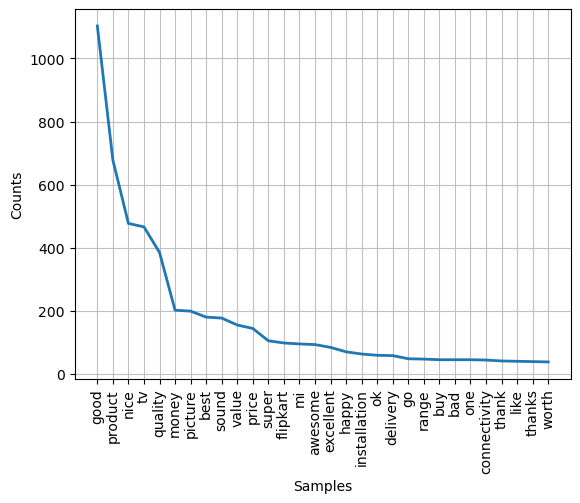

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [14]:
fdist.plot(30)

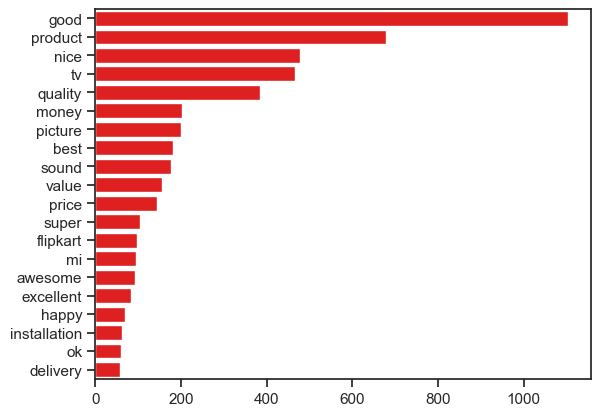

In [15]:
# Obtain top 20 words
top_20 = fdist.most_common(20)

# Create pandas series to make plotting easier
fdist_df = pd.Series(dict(top_20))
sns.set_theme(style="ticks")

sns.barplot(y=fdist_df.index, x=fdist_df.values, color='red');

# Topic modelling on Positive Sentiment Reviews

In [16]:
# Preprocessed positive sentiment reviews
preprocessed_positive_reviews = df[df['Sentiment'] == 'Positive']['Processed_Reviews']

# TF-IDF Vectorization
tfidf_vectorizer_positive_reviews = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix_positive_reviews = tfidf_vectorizer_positive_reviews.fit_transform(preprocessed_positive_reviews)

# Topic Modeling using LDA
lda = LatentDirichletAllocation(n_components=4, random_state=1)
lda.fit(tfidf_matrix_positive_reviews)
# Display the top topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Top Topics for Positive Sentiment Reviews:")
display_topics(lda, tfidf_vectorizer_positive_reviews.get_feature_names(), no_top_words)

Top Topics for Positive Sentiment Reviews:
Topic 1:
good best tv super excellent price value money range budget
Topic 2:
product good awesome mi flipkart thanks thank love service fast
Topic 3:
nice tv happy superb great performance okay led video better
Topic 4:
quality picture sound ok worth good money amazing tv satisfied


C:\Users\prajj\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


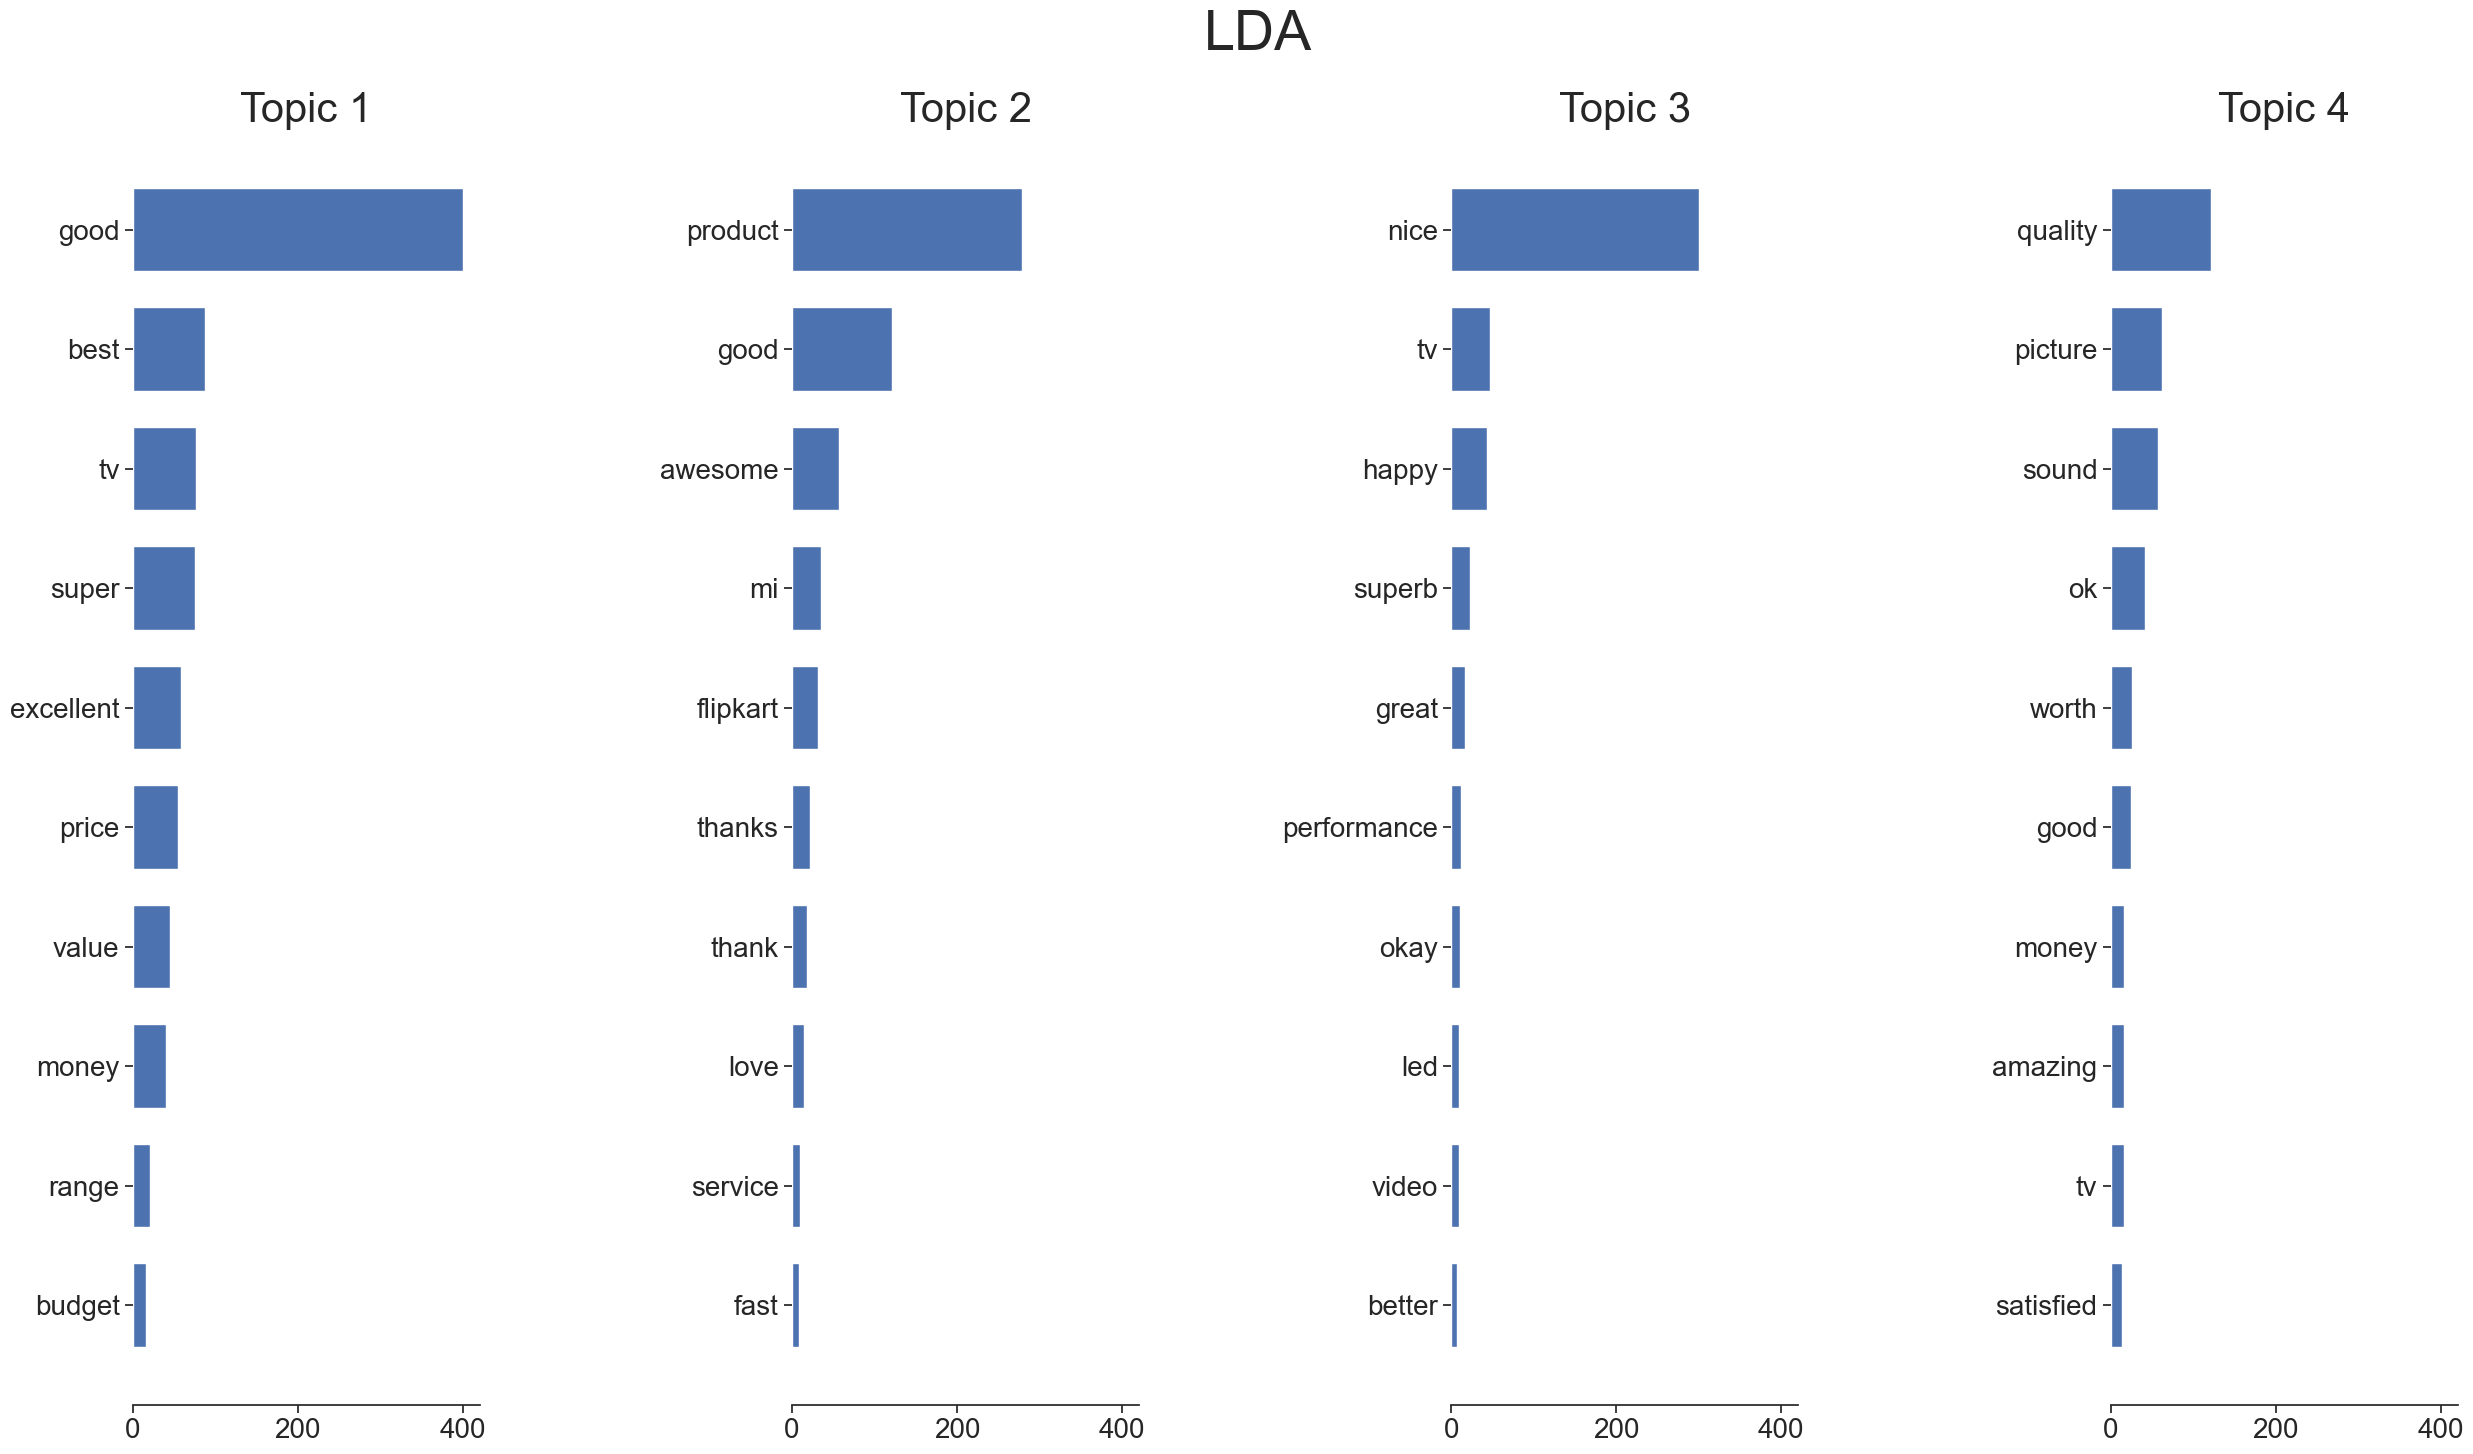

In [17]:
def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('LDA', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

feature_names = tfidf_vectorizer_positive_reviews.get_feature_names()
plot_top_words(lda, feature_names)  

# Clustering on Positive Sentiment Reviews

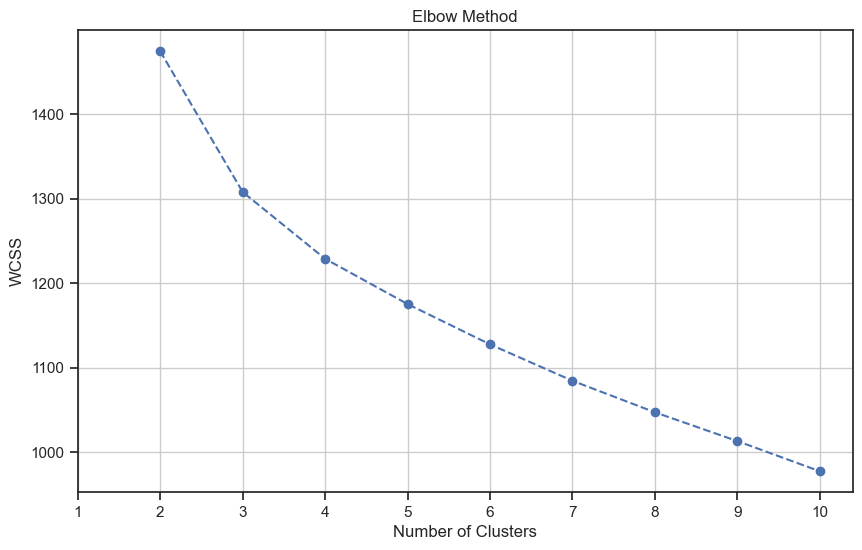

In [18]:
# Calculate WCSS for different values of k
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(tfidf_matrix_positive_reviews)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [19]:
# Performing K-means clustering taking optimum clusters on basis of elbow method
k = 3  #Optimum Number of clusters
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(tfidf_matrix_positive_reviews)
# Display the top words for each cluster
def display_cluster_top_words(model, feature_names, no_top_words):
    for cluster_idx, cluster_center in enumerate(model.cluster_centers_):
        print("Cluster %d:" % (cluster_idx + 1))
        cluster_top_words_indices = cluster_center.argsort()[::-1][:no_top_words]
        cluster_top_words = [feature_names[i] for i in cluster_top_words_indices]
        print(", ".join(cluster_top_words))

no_top_words = 10
print("Top Words for Each Cluster:")
display_cluster_top_words(kmeans, tfidf_vectorizer_positive_reviews.get_feature_names(), no_top_words)

Top Words for Each Cluster:
Cluster 1:
nice, product, tv, mi, good, quality, sound, picture, happy, awesome
Cluster 2:
good, product, quality, picture, sound, overall, tv, game, fine, flipcart
Cluster 3:
good, quality, tv, product, best, super, picture, excellent, price, money


C:\Users\prajj\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 1: Emphasizes satisfaction with the overall experience and features, including the product quality, sound, picture, and happiness with the purchase. Words like "nice," "good," "quality," "sound," and "picture" stand out.

Cluster 2: Highlights similar positive sentiments regarding the product quality, picture, and sound. It also mentions overall satisfaction and possibly mentions specific activities like gaming. Words such as "good," "quality," "picture," "sound," and "game" are prominent.

Cluster 3: Focuses on the product's quality and value for money, indicating that customers perceive it as one of the best options in terms of performance and price. Words like "good," "quality," "best," "excellent," "price," and "money" are notable.

Overall, these clusters suggest that customers appreciate various aspects of the smart TV, including its quality, sound, picture, and value for money. Each cluster may represent a different segment of satisfied customers or highlight different aspects of their satisfaction.

# Topic modelling on Negative Sentiment Reviews

In [20]:
# Preprocessed Negative sentiment reviews
preprocessed_negative_reviews = df[df['Sentiment'] == 'Negative']['Processed_Reviews']

# TF-IDF Vectorization
tfidf_vectorizer_negative_reviews = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix_negative_reviews = tfidf_vectorizer_negative_reviews.fit_transform(preprocessed_negative_reviews)

# Topic Modeling using LDA
lda = LatentDirichletAllocation(n_components=5, random_state=1)
lda.fit(tfidf_matrix_negative_reviews)

# Display the top topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Top Topics for Negative Sentiment Reviews:")
display_topics(lda, tfidf_vectorizer_negative_reviews.get_feature_names(), no_top_words)

Top Topics for Negative Sentiment Reviews:
Topic 1:
poor working tv remote money installation support purchasing item sound
Topic 2:
product worst flipkart buy service sound good mi tv customer
Topic 3:
bad experience installation boy delivery product image app screen ok
Topic 4:
quality picture waste money display bad day came use tv
Topic 5:
slow average connectivity little tv properly worst work pathetic cheating


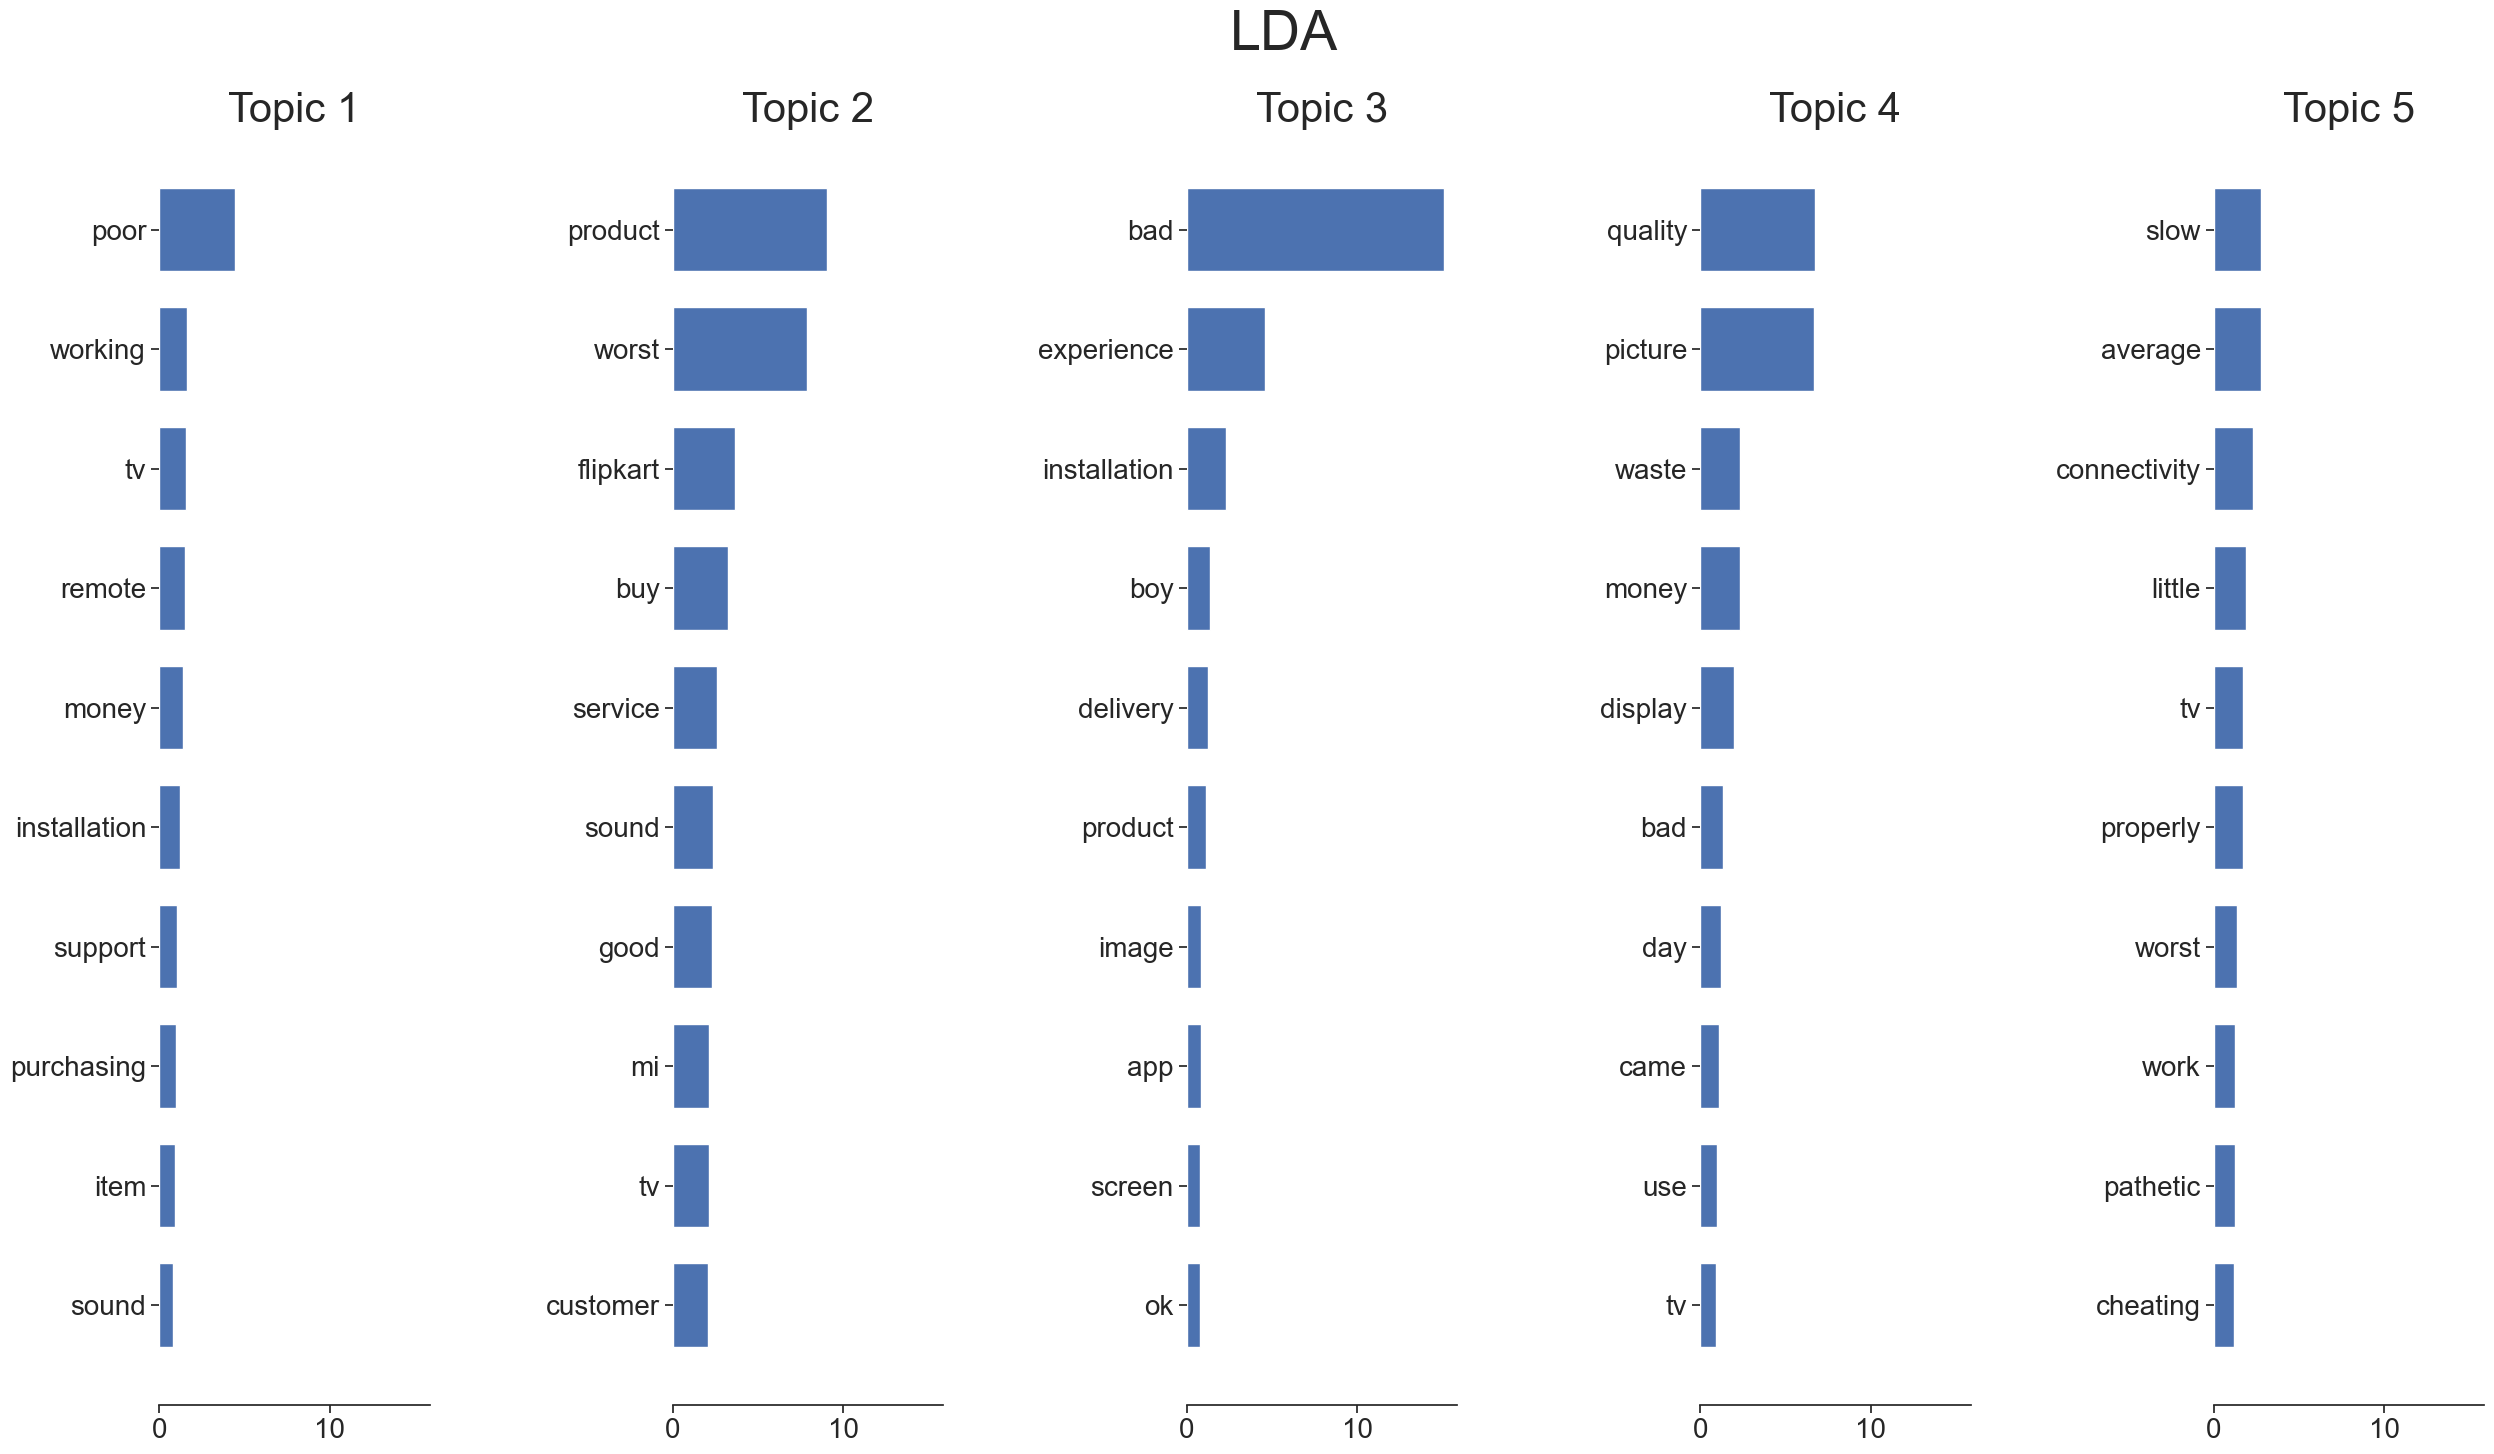

In [21]:
def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('LDA', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

feature_names = tfidf_vectorizer_negative_reviews.get_feature_names()
plot_top_words(lda, feature_names) 

From the topics generated through your negative sentiment reviews on smart TVs, it appears that customers are expressing dissatisfaction with various aspects of their purchase experiences. Here are some insights gleaned from the topics:

Remote and Installation Issues: Topic 1 highlights problems related to the TV remote, installation process, and support services. Customers seem frustrated with difficulties in setting up the TV and issues with the remote control functionality.

Poor Product Experience: Topic 2 indicates dissatisfaction with the product itself, mentioning poor service, sound quality, and negative experiences with purchasing, particularly from Flipkart. This suggests that customers are not only unhappy with the product but also with the service provided by the retailer.

Negative Purchase and Delivery Experiences: Topic 3 reveals discontent with various aspects of the purchase journey, including delivery, product quality, and experiences with installation. Customers mention receiving products that do not match the expected image and encountering issues with apps and screens.

Quality and Display Concerns: Topic 4 emphasizes dissatisfaction with the quality and display of the TV. Customers express feeling like they wasted their money on a product that fails to meet their expectations in terms of picture quality and display performance.

Performance and Connectivity: Topic 5 highlights complaints about the TV's performance, citing issues such as slow operation, poor connectivity, and overall dissatisfaction with its functionality. Customers feel deceived and cheated by the product's performance.

While topic 4 highlights concerns regarding display and quality issues among customers with negative sentiments, our analysis of positive sentiment reviews indicates overall satisfaction with the display and quality of the product. Positive reviews substantially outnumber negative ones, suggesting that the majority of customers are content with their purchases. However, the presence of defective products among the negative reviews signals a need for the company to prioritize quality control measures. By focusing on quality control principles, the company can address these issues and ensure consistently high-quality products for all customers.

# Cluster Analysis on Negative sentiment Reviews

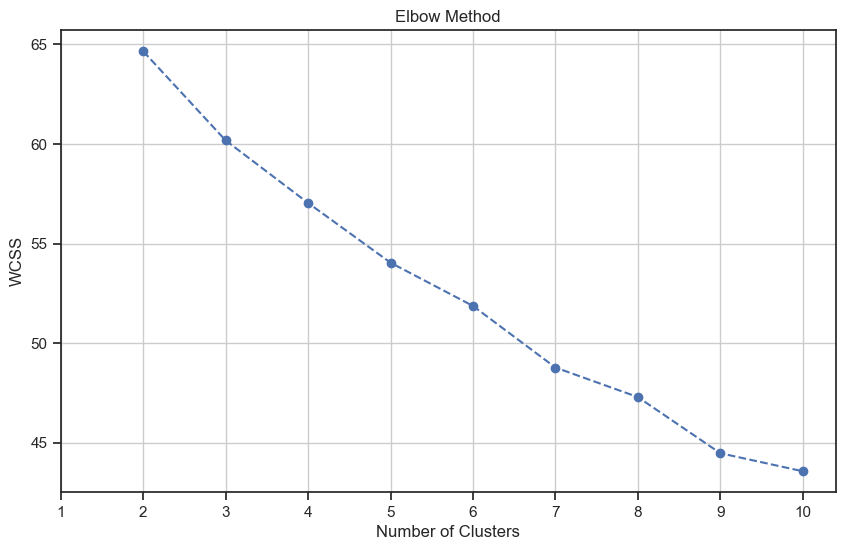

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate WCSS for different values of k
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(tfidf_matrix_negative_reviews)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [23]:
from sklearn.cluster import KMeans
# Perform K-means clustering 
k = 5  # Optimum Number of clusters
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(tfidf_matrix_negative_reviews)
# Display the top words for each cluster
def display_cluster_top_words(model, feature_names, no_top_words):
    for cluster_idx, cluster_center in enumerate(model.cluster_centers_):
        print("Cluster %d:" % (cluster_idx + 1))
        cluster_top_words_indices = cluster_center.argsort()[::-1][:no_top_words]
        cluster_top_words = [feature_names[i] for i in cluster_top_words_indices]
        print(", ".join(cluster_top_words))

no_top_words = 10
print("Top Words for Each Cluster:")
display_cluster_top_words(kmeans, tfidf_vectorizer_negative_reviews.get_feature_names(), no_top_words)

Top Words for Each Cluster:
Cluster 1:
worst, tv, poor, connectivity, slow, disappointed, properly, item, little, flipkart
Cluster 2:
bad, experience, flipkart, sound, boy, time, day, purchase, mi, service
Cluster 3:
product, worst, bad, installation, buy, flipkart, service, good, delivery, customer
Cluster 4:
waste, money, remote, working, connection, buy, product, display, day, delivery
Cluster 5:
picture, quality, bad, sound, poor, app, worst, tv, average, month


C:\Users\prajj\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Based on the cluster analysis of negative sentiment reviews for smart TVs, distinct clusters have emerged, each characterized by specific keywords:

Cluster 1:

Keywords: worst, poor, connectivity, slow, disappointed, properly, item, little, flipkart
Themes: Issues with connectivity, slow performance, and disappointment with the product, possibly related to purchasing from Flipkart.

Cluster 2:

Keywords: bad, experience, flipkart, sound, boy, time, purchase, mi, service
Themes: Negative experiences related to Flipkart, including issues with sound quality, service, and purchase processes.

Cluster 3:

Keywords: product, worst, bad, installation, buy, flipkart, service, delivery, customer
Themes: Criticisms regarding the product itself, encompassing problems with installation, purchasing experience, and customer service, particularly associated with Flipkart.

Cluster 4:

Keywords: waste, money, remote, working, connection, buy, product, display, day, delivery
Themes: Complaints about the product's value, remote functionality, connectivity issues, and overall dissatisfaction with the purchase experience.

Cluster 5:

Keywords: picture, quality, bad, sound, poor, app, worst, tv, average, month
Themes: Criticisms related to picture and sound quality, as well as issues with apps and overall dissatisfaction over a prolonged period, possibly a month.
These clusters provide insights into the specific pain points and recurring issues highlighted by customers in their negative reviews. Understanding these clusters can guide the company in addressing key areas for improvement, such as product quality, service, delivery, and customer experience.

# Phase 2: 

In [24]:
# Sort the DataFrame by Dates in descending order to get the most recent 25% of reviews
df_sorted = df.sort_values(by='Dates', ascending=False)

# Calculate the index to slice the most recent 25% of reviews
index_25_percent = int(0.25 * len(df_sorted))

# Get the most recent 25% of reviews
recent_reviews_df = df_sorted.head(index_25_percent)

In [25]:
# Overall sentiment
overall_sentiment = recent_reviews_df['Sentiment'].value_counts(normalize=True)
print("Overall Sentiment Distribution:")
print(overall_sentiment)

Overall Sentiment Distribution:
Positive    0.888696
Neutral     0.062609
Negative    0.048696
Name: Sentiment, dtype: float64


# Topic modelling on most Recent Negative Sentiment Reviews

Top Topics for Negative Sentiment Reviews:
Topic 1:
bad experience installation picture quality service product customer good buy
Topic 2:
product like mi flipkart service tv good buy customer experience
Topic 3:
bought flipkart issue like contact care quality bad worst service
Topic 4:
worst buy sound quality day tv picture brand contact care
Topic 5:
tv bought service good worst product brand mi customer care


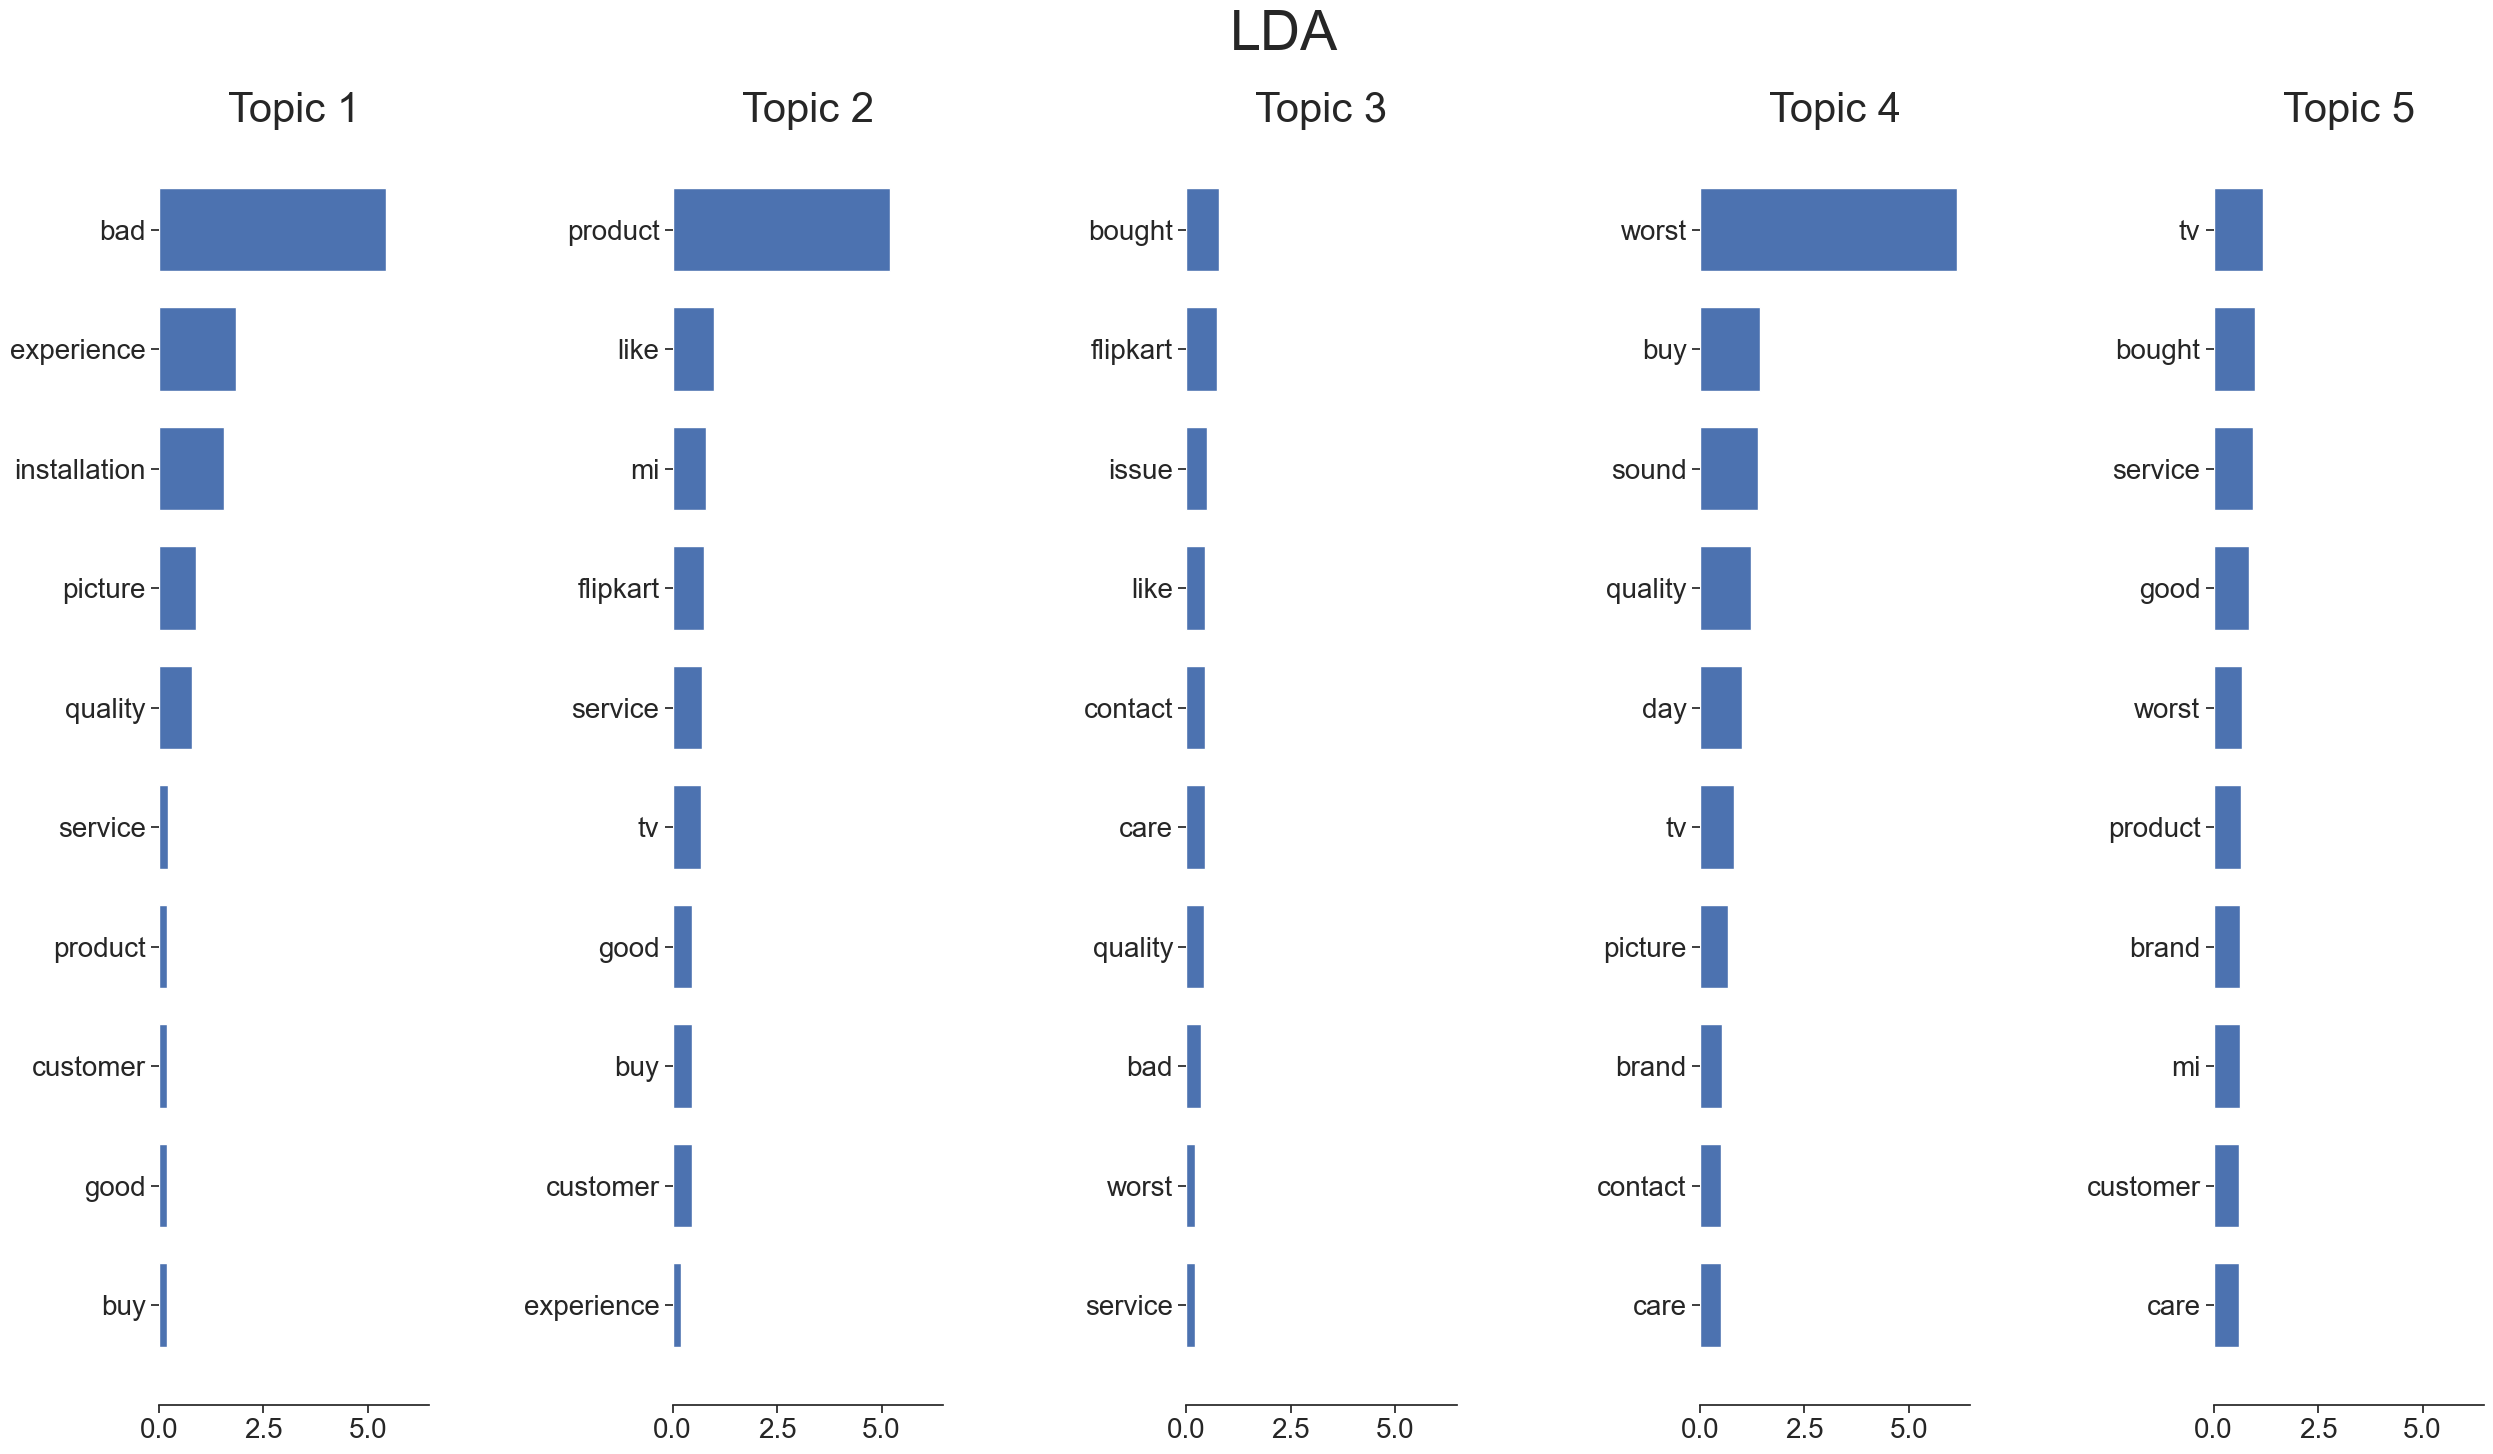

In [32]:
# Preprocessed Negative sentiment reviews
preprocessed_recent_negative_reviews = recent_reviews_df[recent_reviews_df['Sentiment'] == 'Negative']['Processed_Reviews']

# TF-IDF Vectorization
tfidf_vectorizer_recent_negative_reviews = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix_recent_negative_reviews = tfidf_vectorizer_recent_negative_reviews.fit_transform(preprocessed_recent_negative_reviews)

# Topic Modeling using LDA
lda = LatentDirichletAllocation(n_components=5, random_state=1)
lda.fit(tfidf_matrix_recent_negative_reviews)

# Display the top topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Top Topics for Recent Negative Sentiment Reviews:")
display_topics(lda, tfidf_vectorizer_recent_negative_reviews.get_feature_names_out(), no_top_words)


def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('LDA', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

feature_names_recent_negative = tfidf_vectorizer_recent_negative_reviews.get_feature_names_out()
plot_top_words(lda, feature_names_recent_negative) 

There are some common themes across both the entire set of negative sentiment reviews and the most recent ones. 
Persistent Issues:

Installation and Service: "Bad experience installation," "service," "customer care" - This indicates that issues related to installation and after-sales service continue to be prominent concerns for customers.

Product Quality: "Picture quality," "sound quality," "brand" - Quality-related issues such as poor picture or sound quality, and concerns about the brand's overall quality, remain consistent problems.

Buying Experience: "Worst buy," "buying experience," "bought" - Negative experiences with purchasing the product, possibly indicating dissatisfaction with the buying process itself.

There are issues that seem to have been resolved based on the recent negative sentiment reviews:

Connectivity Issues: The absence of mentions related to connectivity issues, such as "slow," "connectivity," or "pathetic," implies that the company might have improved the connectivity aspects of their products, leading to a reduction in complaints regarding this issue.

Delivery and Installation: While "installation" still appears as an issue in the recent reviews, there are no explicit complaints about delivery, suggesting that the company may have improved its delivery process. However, since installation concerns persist, it indicates that there's still room for improvement in this aspect.

# Phase 3

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [34]:
df.head()

,Rating,Short_Reviews,reviews,Names,Dates,Likes,Dislikes,Number_Images,Processed_Reviews,Sentiment_Score,Sentiment,polarity,subjectivity
0,5,Must buy!,Nice,Rupesh Kumar,1 month ago,86,24,1,nice,0.60,Positive,0.60,1.0
1,5,Mind-blowing purchase,Good 👍👍👍,Flipkart Customer,2 months ago,39,9,1,good,0.70,Positive,0.70,0.6
2,5,Terrific purchase,I Love this mi tv. All good no problem on this...,DAITARI MAJHI,4 months ago,41,11,3,love mi tv good problem tv,0.60,Positive,0.60,0.6
3,5,Must buy!,"Very good product, picture quality awesome",Bapi Saha,4 months ago,28,8,2,good product picture quality awesome,0.85,Positive,0.85,0.8
4,1,Hated it!,Display picture is worst 😭,Jagajeevan Reddy,2 months ago,25,7,0,display picture worst,-1.00,Negative,-1.00,1.0


In [35]:
df["review_length"] = df["Processed_Reviews"].apply(lambda x : len(x))

In [38]:
df_filtered = df[['Processed_Reviews', 'Dislikes', 'Likes', 'review_length', 'Number_Images']]

In [39]:
df_filtered.head()

,Processed_Reviews,Dislikes,Likes,review_length,Number_Images
0,nice,24,86,4,1
1,good,9,39,4,1
2,love mi tv good problem tv,11,41,26,3
3,good product picture quality awesome,8,28,36,2
4,display picture worst,7,25,21,0


In [57]:
# Split the data into features (X) and target (y)
X = df_filtered[['Processed_Reviews', 'review_length', 'Number_Images']]
y = df_filtered['Likes']  

In [58]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [59]:
# Create TF-IDF vectors for the processed review text
tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train['Processed_Reviews'])
X_test_tfidf = tfidf.transform(X_test['Processed_Reviews'])

In [60]:
feature_names = tfidf.get_feature_names_out()

In [61]:
feature_names

array(['10', '100', '1080p', '10k', '11', '15', '15k', '2023', '20w',
       '32', '32inch', '43', '5g', 'absolutely', 'access', 'according',
       'adding', 'affordable', 'already', 'also', 'always', 'amazing',
       'amount', 'android', 'app', 'application', 'apps', 'arc', 'atmos',
       'attached', 'audio', 'auto', 'automatic', 'automatically', 'av',
       'available', 'average', 'awesome', 'awow', 'awsm', 'awsome', 'bad',
       'bar', 'bass', 'bast', 'bat', 'bazelless', 'bbd', 'beautiful',
       'bed', 'behaviour', 'best', 'better', 'bhalo', 'big', 'billion',
       'bit', 'black', 'blame', 'bler', 'blind', 'blindly', 'blinking',
       'blowing', 'blu', 'bluetooth', 'bought', 'box', 'boy', 'brand',
       'bright', 'brightness', 'brilliant', 'bt', 'budget', 'budgeted',
       'build', 'buy', 'buying', 'cable', 'call', 'came', 'cannot',
       'care', 'cast', 'casting', 'channel', 'cheap', 'check', 'choice',
       'clarity', 'class', 'clear', 'clip', 'close', 'color', 'colou

In [62]:
# Combine TF-IDF vectors with other features for training data
X_train_final = pd.concat([
    pd.DataFrame(X_train_tfidf.toarray()).add_prefix('review_'), 
    X_train.drop('Processed_Reviews', axis=1).reset_index(drop=True).astype(float)
], axis=1)

In [63]:
# Combine TF-IDF vectors with other features for testing data
X_test_final = pd.concat([
    pd.DataFrame(X_test_tfidf.toarray()).add_prefix('review_'), 
    X_test.drop('Processed_Reviews', axis=1).reset_index(drop=True).astype(float)
], axis=1)

In [64]:
# Train a Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train_final, y_train)

RandomForestRegressor(random_state=1)

In [65]:
# Predict on the test set
y_pred = rf_model.predict(X_test_final)

In [66]:
# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2.11409009146585


In [67]:
# Feature importance
feature_names = list(tfidf.get_feature_names_out()) + list(X_train.drop('Processed_Reviews', axis=1).columns)

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})



# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print top features
print("Top factors contributing to helpfulness prediction:")
print(feature_importance.head(10))

Top factors contributing to helpfulness prediction:
           Feature  Importance
387           slim    0.320923
493          worst    0.132484
318        problem    0.121210
501  Number_Images    0.090725
500  review_length    0.033604
57           black    0.025815
191           good    0.022566
275           nice    0.018831
305        picture    0.018225
131        display    0.014512



We have build the model to predict the likability of reviews, using features extracted from processed review text along with review length, number of images, and other features. Here are some insights based on the that:

Feature Importance:

The top factors contributing to the likability prediction include terms like "slim," "worst," "problem," "good," "nice," "picture," and "display." These terms indicate that the sentiment and specific characteristics mentioned in the reviews play a significant role in determining their likability.

Among non-text features, "Number_Images" and "review_length" also contribute to the prediction, suggesting that the presence of images and the length of the review can influence how likable it is.

Overall, these insights can help you understand what aspects of reviews drive their likability and can be used to enhance the effectiveness of our review analysis .